# Alzheimer's Detection 







## **1. Setup ENV, download/import dependencies**

In [ ]:

import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
#from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
from keras.applications.densenet import DenseNet121
import seaborn as sns
sns.set()


from IPython.display import display
import time
import warnings
import os                   
from random import shuffle  
from zipfile import ZipFile

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from fastai import *
from fastai.vision import *
from fastai.callbacks import Callback
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateauCallback
from fastai.data_block import MultiCategoryList
import cv2 
from tqdm import tqdm
from sklearn.utils import shuffle


%matplotlib inline

EPOCHS = 50
BATCH_SIZE = 16
SEED = 20031
LRATE = 0.00005
VERBOSE=0


## **2. Load Datasets**

In [2]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

train_df = pd.read_csv('Alzheimers-ADNI/train.csv')
test_df = pd.read_csv('Alzheimers-ADNI/test.csv')
print("Datasets loaded..")

Datasets loaded..


## **3. Exploratory Data Analysis**

,id_code,diagnosis
0,0,0
1,1,0


,id_code
0,1101
1,1102


train_df shape =  (1101, 2)
test_df shape =  (195, 1)


0    493
1    204
2    198
4    145
3     61
Name: diagnosis, dtype: int64

C:\Users\kisha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='diagnosis', ylabel='count'>

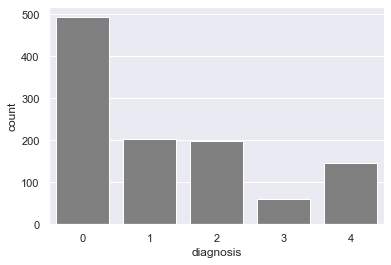

In [116]:
# Data
import seaborn as sns
display(train_df.head(2))
display(test_df.head(2))

# Shape of data
print("train_df shape = ",train_df.shape)
print("test_df shape = ",test_df.shape)

# Distribution of data
display(train_df['diagnosis'].value_counts())
sns.countplot(train_df['diagnosis'], color='gray')

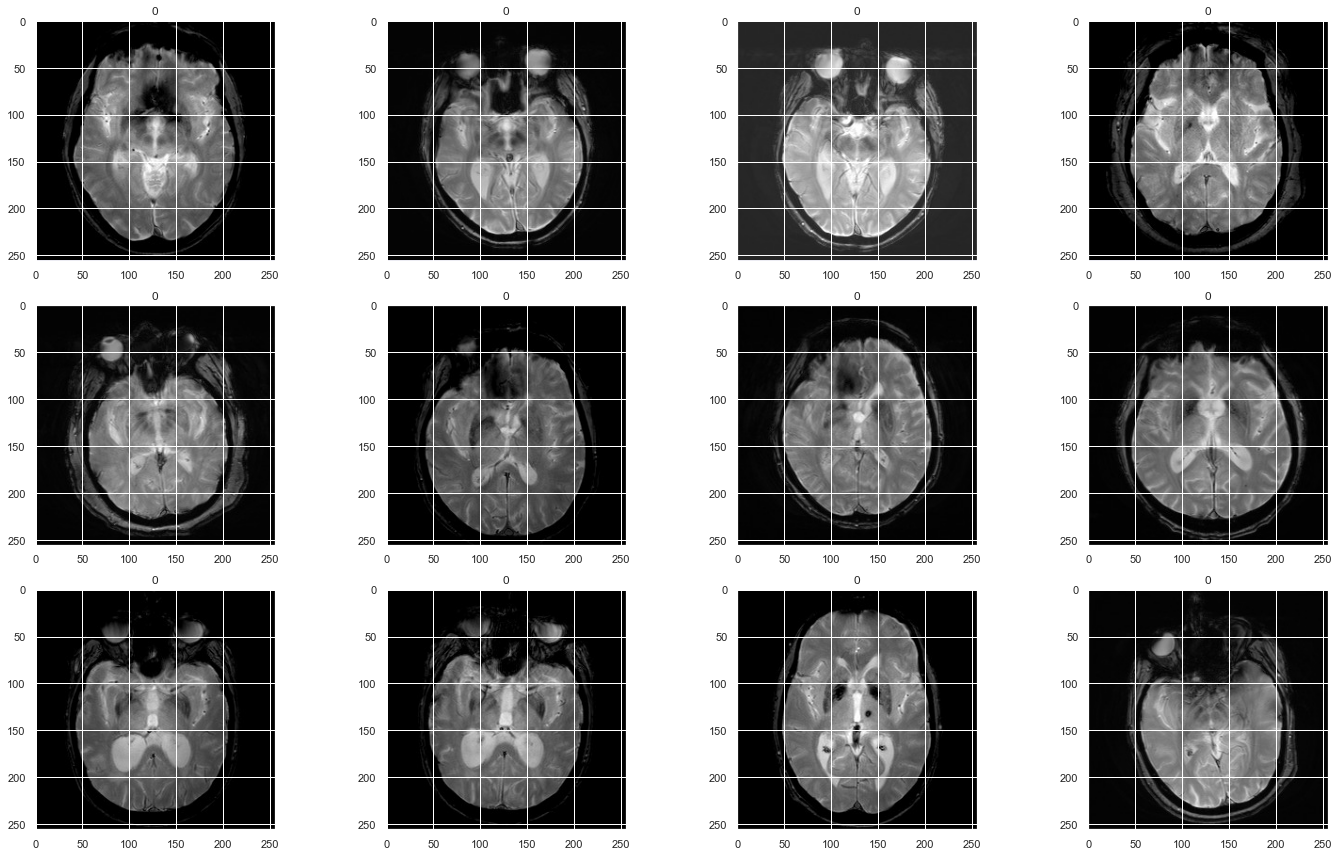

In [118]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'Alzheimers-ADNI/train/{image_path}.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

## **4. Perform Pre-processing, Resampling**

In [119]:
IMG_SIZE=224

def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def CLAHEgreen(image):
    green=image[:, :, 1]
    clipLimit = 2.0
    tileGridSize = (8,8)
    clahe=cv2.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)
    cla=clahe.apply(green)
#     cla=clahe.apply(cla)
    img=cv2.merge((cla,cla,cla))
    
    return img


    
def preprocess_image(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    image=CLAHEgreen(image)
        
    return image


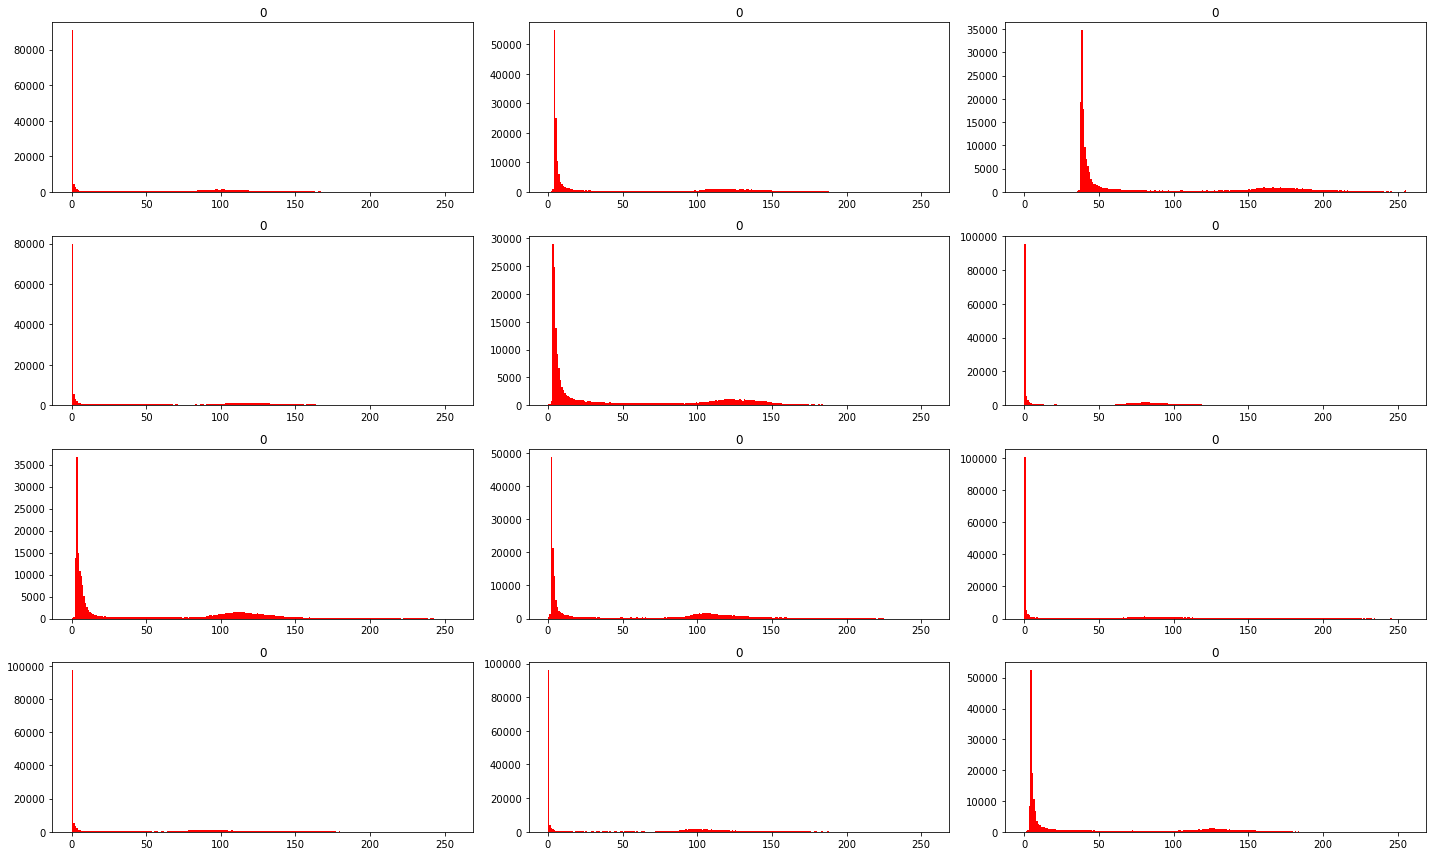

In [9]:
def get_histograms(df,columns=4, rows=3):
    ax, fig=plt.subplots(columns*rows,figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        plt.subplot(columns, rows, i+1)
        img = cv2.imread(f'Alzheimers-ADNI/train/{image_path}.jpg')
        plt.hist(img.flatten(),256,[0,256],color='r')
#         fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
#         plt.axis('off')
#         plt.imshow(img)
    
    plt.tight_layout() 

get_histograms(train_df)



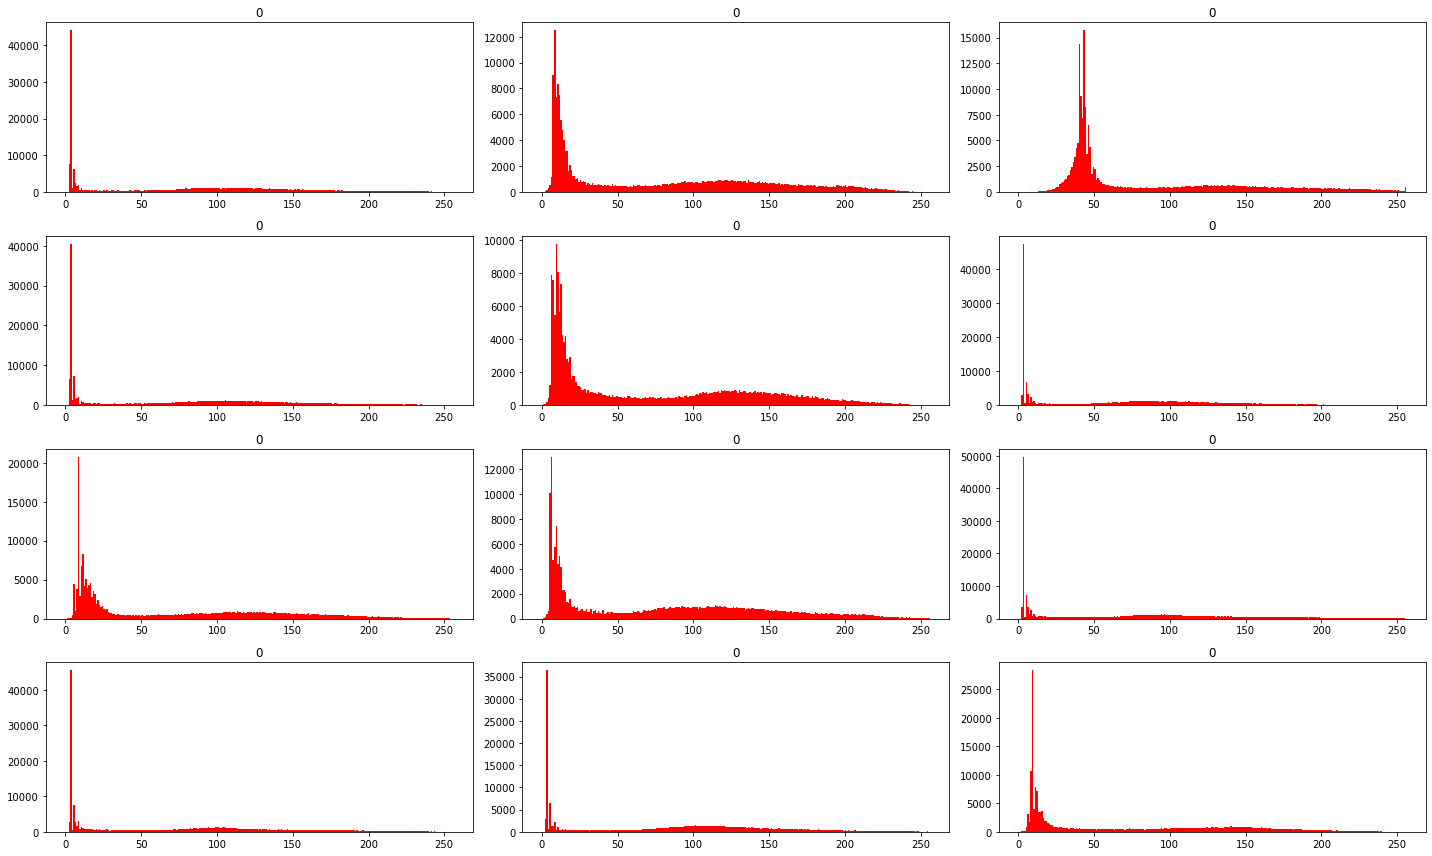

In [14]:
def get_histograms_preprocess(df,columns=4, rows=3):
    ax, fig=plt.subplots(columns*rows,figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        plt.subplot(columns, rows, i+1)
        img = preprocess_image(f'Alzheimers-ADNI/train/{image_path}.jpg')
        plt.hist(img.flatten(),256,[0,256],color='r')
#         fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
#         plt.axis('off')
#         plt.imshow(img)
    
    plt.tight_layout()    

    
get_histograms_preprocess(train_df)

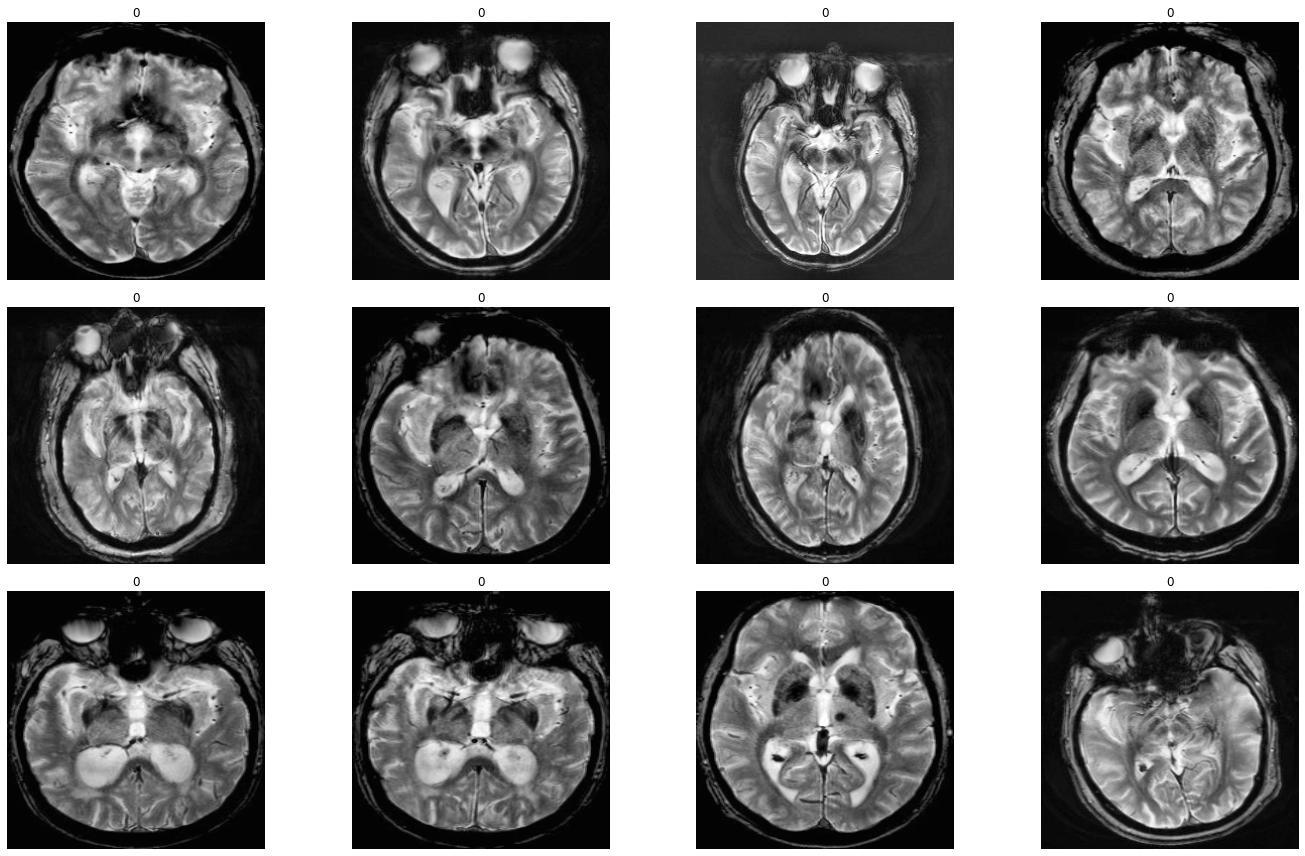

In [15]:
def display_samples_gaussian(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = preprocess_image(f'Alzheimers-ADNI/train/{image_path}.jpg')
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()

display_samples_gaussian(train_df)

In [120]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224,3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'Alzheimers-ADNI/train/{image_id}.jpg')

100%|██████████| 1101/1101 [00:06<00:00, 169.05it/s]


In [121]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224,3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :,: ] = preprocess_image(
        f'Alzheimers-ADNI/test/{image_id}.jpg'
    )

100%|██████████| 195/195 [00:01<00:00, 165.62it/s]


In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values

In [123]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(1101, 224, 224, 3)
(1101, 5)
(195, 224, 224, 3)


In [125]:

from imblearn.over_sampling import SMOTE, ADASYN
x_resampled, y_resampled = SMOTE(random_state=SEED).fit_resample(x_train.reshape(x_train.shape[0], -1), train_df['diagnosis'].ravel())

print("x_resampled.shape=",x_resampled.shape)
print("y_resampled.shape=",y_resampled.shape)

x_train = x_resampled.reshape(x_resampled.shape[0], 224, 224, 3)
y_train = pd.get_dummies(y_resampled).values



# Each class should have 1000 samples now (5 x 1000 = 5000)
print("x_train.shape=",x_train.shape)
print("y_train.shape=",y_train.shape)

x_resampled.shape= (2465, 150528)
y_resampled.shape= (2465,)
x_train.shape= (2465, 224, 224, 3)
y_train.shape= (2465, 5)


# 5.Creating Multilabels
Encoding a class by encompassing all the classes before it seems to work out well for kappa scores. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., encoding a class 4  would usually be [0, 0, 0, 1, 0], but in our case we will predict [1, 1, 1, 1, 0]. 

In [126]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [493 493 493 493 493]
Multilabel version: [2465 1972 1479  986  493]


In [9]:
# Split 85-15 training-validation sets
x_sptrain, x_spval, y_sptrain, y_spval = train_test_split(
    x_train, y_train_multi, 
    test_size=0.10, 
    random_state=SEED
)
print("train-validation splitted ...")

train-validation splitted ...


# 6. Image Data Augmentation

In [10]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.10,        # set range for random zoom
        fill_mode='constant',   # set mode for filling points outside the input boundaries
        cval=0.,                # value used for fill_mode = "constant"
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images
        #rotation_range=20       # Degree range for random rotations
    )

# Using original generator
data_generator = create_datagen().flow(x_sptrain, y_sptrain, batch_size=BATCH_SIZE, seed=SEED)
print("Image data augmentated ...")

Image data augmentated ...


# 7. CNNetwork Architecture (DenseNet

In [11]:
# Define evaluation metrics

import keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*(p*r) / (p+r+K.epsilon())

print("Evaluation metrics defined ...")

Evaluation metrics defined ...


In [ ]:
def get_preds(arr):
    mask = arr == 0
    return np.clip(np.where(mask.any(1), mask.argmax(1), 5) - 1, 0, 4)

class ConfusionMatrix(Callback):
    "Computes the confusion matrix."

    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        preds = torch.tensor(get_preds((torch.sigmoid(last_output) > 0.5).cpu().numpy()))
        
        targs = torch.tensor(get_preds(last_target.cpu().numpy()))

        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm
        

@dataclass
class KappaScore(ConfusionMatrix):
    "Compute the rate of agreement (Cohens Kappa)."
    weights:Optional[str]=None      # None, `linear`, or `quadratic`

    def on_epoch_end(self, last_metrics, **kwargs):
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)


@dataclass
class ChangeDataOnEpoch(Callback):
    learn:Learner
    i:int
        
    def on_epoch_end(self, **kwargs):
        print(f'Data seed {self.i}')
        self.learn.data = get_data(seed=self.i)
        self.learn.data.add_tfm(batch_to_half)
        self.i += 1

In [ ]:
class FlattenedLoss():
    
    def __init__(self, func, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func,self.axis,self.floatify,self.is_2d = func(*args,**kwargs),axis,floatify,is_2d
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        input = input.transpose(self.axis,-1).contiguous()
        target = target.transpose(self.axis,-1).contiguous()
        if self.floatify: target = target.float()
            
        # Label smoothing experiment
        target = (target * 0.9 + 0.05)
        target[:,0] = 1

        input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        return self.func.__call__(input, target.view(-1), **kwargs)

    
def LabelSmoothBCEWithLogitsFlat(*args, axis:int=-1, floatify:bool=True, **kwargs):
    
    return FlattenedLoss(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [130]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.optimizers import Adam

In [12]:
# Transfer Learning
densenet = DenseNet121(
    weights='DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=LRATE),
    metrics=[accuracy,mean_pred, precision, recall, f1_score, fbeta_score, fmeasure]
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
ef get_data(seed, size=IMG_SIZE):
    df_train = get_train_df(seed)
    data = (
        ImageList.from_df(
            path='./',
            df=df_train,
            folder='.'
        )
    )
    data = (data.split_from_df('is_valid')
            .label_from_df('label', label_delim=',', label_cls=ReconstructFixMultiCategoryList)
            .transform(
                (train_tfms, val_tfms),
                resize_method=ResizeMethod.NO,
                padding_mode='zeros')
            .databunch(bs=BS)
            .normalize(imagenet_stats))
    data.add_test(ImageList.from_df(sample_df, './Alzheimers-ADNI', folder='test', suffix='.jpg'))
    return data

In [ ]:
def get_efficientnet(name, pretrained, model_path):
    
    model = efficientnet_pytorch.EfficientNet.from_name(f'efficientnet-{name}', override_params={'num_classes': 5})
    if pretrained:
        model_state = torch.load(model_path)
        # load original weights apart from its head
        if '_fc.weight' in model_state.keys():
            model_state.pop('_fc.weight')
            model_state.pop('_fc.bias')
            res = model.load_state_dict(model_state, strict=False)
            print('Loaded pretrained')
            assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
        else:
           
            from collections import OrderedDict
            mapping = { i:o for i,o in zip(model_state.keys(), model.state_dict().keys()) }
            mapped_model_state = OrderedDict([
                (mapping[k], v) for k,v in model_state.items() if not mapping[k].startswith('_fc')
            ])
            res = model.load_state_dict(mapped_model_state, strict=False)
    return model

# 8. Training Model

In [13]:
# callback to keep track of kappa score during training
class KappaMetrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []
        
    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"Epoch: {epoch+1} val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return
    
kappa_score = KappaMetrics()



history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_spval, y_spval),
    callbacks=[kappa_score],
    verbose=VERBOSE
)    

Epoch: 1 val_kappa: 0.7832
Validation Kappa has improved. Saving model.
Epoch: 2 val_kappa: 0.8249
Validation Kappa has improved. Saving model.
Epoch: 3 val_kappa: 0.8727
Validation Kappa has improved. Saving model.
Epoch: 4 val_kappa: 0.8531
Epoch: 5 val_kappa: 0.8371
Epoch: 6 val_kappa: 0.7572
Epoch: 7 val_kappa: 0.8649
Epoch: 8 val_kappa: 0.8743
Validation Kappa has improved. Saving model.
Epoch: 9 val_kappa: 0.8483
Epoch: 10 val_kappa: 0.8328
Epoch: 11 val_kappa: 0.8816
Validation Kappa has improved. Saving model.
Epoch: 12 val_kappa: 0.8826
Validation Kappa has improved. Saving model.
Epoch: 13 val_kappa: 0.8932
Validation Kappa has improved. Saving model.
Epoch: 14 val_kappa: 0.9059
Validation Kappa has improved. Saving model.
Epoch: 15 val_kappa: 0.8724
Epoch: 16 val_kappa: 0.9075
Validation Kappa has improved. Saving model.
Epoch: 17 val_kappa: 0.8988
Epoch: 18 val_kappa: 0.9077
Validation Kappa has improved. Saving model.
Epoch: 19 val_kappa: 0.8971
Epoch: 20 val_kappa: 0.9007

In [ ]:
kappa = KappaScore(weights="quadratic")
change_data_cb = partial(ChangeDataOnEpoch, i=SEED)

model = get_efficientnet('b3', True, './efficientnet-b3-c8376fa2.pth')

learn = Learner(data, model, metrics=[kappa, accuracy_thresh], model_dir=".", callback_fns=[change_data_cb, BnFreeze])
learn.loss_func = LabelSmoothBCEWithLogitsFlat()
learn.split(lambda m: (m._conv_head,) );
learn = learn.to_fp16()
learn.freeze()

# 9. Evaluate model using metrics

In [14]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df.head(EPOCHS)

,val_loss,val_acc,val_mean_pred,val_precision,val_recall,val_f1_score,val_fbeta_score,val_fmeasure,loss,acc,mean_pred,precision,recall,f1_score,fbeta_score,fmeasure
0,0.236658,0.9044,0.573155,0.963874,0.878969,0.918434,0.918434,0.918434,0.348655,0.837510,0.557134,0.882747,0.842761,0.857787,0.857787,0.857787
1,0.185501,0.9144,0.615643,0.939431,0.921527,0.928828,0.928828,0.928828,0.208263,0.912210,0.588818,0.938110,0.916794,0.925587,0.925587,0.925587
2,0.155852,0.9356,0.606033,0.963628,0.931274,0.946401,0.946401,0.946401,0.179800,0.925420,0.595252,0.947628,0.929698,0.937232,0.937232,0.937232
3,0.161536,0.9284,0.625161,0.944945,0.941351,0.941444,0.941444,0.941444,0.160173,0.935548,0.595641,0.951936,0.942342,0.945590,0.945590,0.945590
4,0.171891,0.9312,0.608844,0.959982,0.927109,0.941881,0.941881,0.941881,0.145000,0.941873,0.602757,0.956806,0.948555,0.951334,0.951334,0.951334
5,0.246283,0.9056,0.545336,0.982798,0.862948,0.917031,0.917031,0.917031,0.124395,0.950761,0.597708,0.962564,0.956456,0.958547,0.958547,0.958547
6,0.168010,0.9336,0.603160,0.959336,0.933223,0.945052,0.945052,0.945052,0.110472,0.955765,0.593460,0.964226,0.962206,0.962312,0.962312,0.962312
7,0.149917,0.9432,0.600551,0.969852,0.938260,0.952556,0.952556,0.952556,0.102221,0.960809,0.598591,0.967974,0.967893,0.967124,0.967124,0.967124
8,0.218598,0.9304,0.563934,0.985148,0.902184,0.940769,0.940769,0.940769,0.091204,0.965733,0.597784,0.973573,0.970477,0.971413,0.971413,0.971413
9,0.173399,0.9324,0.588793,0.967832,0.921075,0.942640,0.942640,0.942640,0.081217,0.969302,0.596671,0.974825,0.974143,0.973907,0.973907,0.973907


'Maximum Kappa Score: 0.9269737940243699'

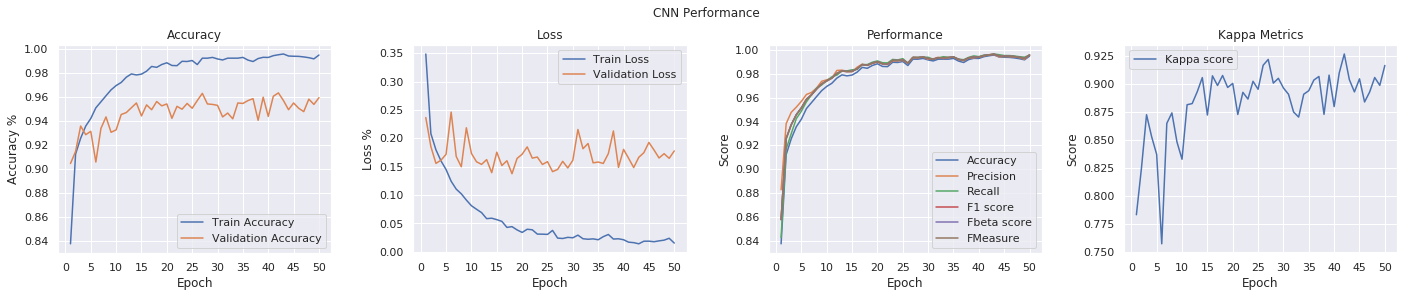

In [15]:


f1, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
t1 = f1.suptitle('CNN Performance', fontsize=12)
f1.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS + 1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax1.set_ylabel('Accuracy %')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax2.set_ylabel('Loss %')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax3.plot(epoch_list, history.history['acc'], label='Accuracy')
ax3.plot(epoch_list, history.history['precision'], label='Precision')
ax3.plot(epoch_list, history.history['recall'], label='Recall')
ax3.plot(epoch_list, history.history['f1_score'], label='F1 score')
ax3.plot(epoch_list, history.history['fbeta_score'], label='Fbeta score')
ax3.plot(epoch_list, history.history['fmeasure'], label='FMeasure')
ax3.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax3.set_ylabel('Score')
ax3.set_xlabel('Epoch')
ax3.set_title('Performance')
l3 = ax3.legend(loc="best")

ax4.plot(epoch_list, kappa_score.val_kappas, label='Kappa score')
ax4.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax4.set_ylabel('Score')
ax4.set_xlabel('Epoch')
ax4.set_title('Kappa Metrics')
l4 = ax4.legend(loc="best")

display("Maximum Kappa Score: %s" %max(kappa_score.val_kappas))

** Observation: ** Model has shown good learning capability. It seems to generalize well since training vs validation accuracy are within 4% and loss within 0.1%. We can increase few more epoch to further train to acheive better kappa score without starting to overfit.

# 10. Predict results


In [39]:
preds, y = model.get_preds(ds_type=DatasetType.Test)

In [40]:
preds

tensor([[1.0000, 0.9289, 0.7993, 0.0669, 0.0521],
        [1.0000, 0.9508, 0.9545, 0.7578, 0.0859],
        [1.0000, 0.9466, 0.9527, 0.6375, 0.0523],
        ...,
        [1.0000, 0.9476, 0.9572, 0.0942, 0.0438],
        [1.0000, 0.9483, 0.9353, 0.5063, 0.1168],
        [1.0000, 0.9595, 0.9356, 0.0846, 0.0623]])

In [43]:
test_df.diagnosis = get_preds((preds > 0.5).cpu().numpy())
test_df.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,0


In [45]:
test_preds_df = pd.concat([
    test_df,
    pd.DataFrame(preds.numpy())
], axis=1)
test_preds_df.head(5)

,id_code,diagnosis,0,1,2,3,4
0,0005cfc8afb6,2,1.0,0.928926,0.799286,0.066934,0.052134
1,003f0afdcd15,3,1.0,0.950778,0.954478,0.757794,0.085862
2,006efc72b638,3,1.0,0.946597,0.952662,0.637482,0.052328
3,00836aaacf06,2,1.0,0.945500,0.944074,0.054099,0.056757
4,009245722fa4,2,1.0,0.962953,0.960212,0.042563,0.034165
